In [158]:
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from datetime import datetime, timedelta
from contextlib import contextmanager

import seaborn as sns
from pathlib import Path
from dateutil.parser import isoparse
import numpy as np
import pandas as pd

from collections import defaultdict

from balsam.api import Job, EventLog, BatchJob
from balsam.schemas import EventOrdering
from balsam.analytics import throughput_report, utilization_report, available_nodes

%matplotlib inline
#mpl.use('pdf')
sns.set_context("paper", font_scale=1)
plt.rc('font', family='serif', serif='Times', size=8)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
plt.rc('legend', fontsize=8)
mpl.rc('text', usetex = True)

COLWIDTH = 3.42
FULLWIDTH = 6.97

@contextmanager
def inline_plot():
    try:
        mpl.use("module://ipykernel.pylab.backend_inline")
        %matplotlib inline
        yield
    finally:
        mpl.use("pdf")

def autolabel(ax, rects, values=None, fontsize=None, offset=0):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i, rect in enumerate(rects):
        height = rect.get_height() if values is None else values[i]
        ax.annotate('{:.1f}'.format(height),
                    xy=(offset + rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=fontsize)
        
def multi_barplot(ax, x_labels, legend_labels, *datasets, height_labels=None, color_offset=0, fontsize=None):
    x = np.arange(len(x_labels))  # the label locations
    rects = []
    offsets = {
        1: [0.0],
        2: [-0.25, 0.0],
        3: [-0.375, -0.125, 0.125],
    }[len(datasets)]
    width = {
        1: 0.5,
        2: 0.25,
        3: 0.25,
    }[len(datasets)]
    
    label_offsets = {
        0: -0.05,
        1: 0.05,
    }
    
    for i, data in enumerate(datasets):
        assert len(data) == len(x_labels)
        color = sns.color_palette()[i+color_offset]
        rect = ax.bar(x + offsets[i], data, width, label=(legend_labels[i] if legend_labels else None), color=color)
        rects.append(rect)

    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    if legend_labels:
        assert len(legend_labels) == len(datasets)
        ax.legend()
    if height_labels:
        for labelset, rect in zip(height_labels, rects):
            autolabel(ax, rect, labelset, fontsize=fontsize)
    else:
        for i, rect in enumerate(rects):
            autolabel(ax, rect, fontsize=fontsize, offset=label_offsets[i])
            
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

#  Batch Cluster

In [159]:
top = Path("data/batch-cluster-experiments")
theta_top = Path("/projects/WorkExpFacil/msalim/batch-cluster-experiments/")

run_logs = list(top.glob("*.log"))
run_names_theta = [run_log.with_suffix("").name for run_log in run_logs]


def load_submit_times(run_log, original_dir):
    result = {}
    with open(run_log) as fp:
        for line in fp:
            if line.startswith("SUBMITTED:"):
                _, job_path, tstr = line.split()
                job_path = Path(job_path).relative_to(original_dir)
                result[job_path] = isoparse(tstr)
    return result

submit_times = {}
for run_log in run_logs:
    run_name = run_log.with_suffix("").name
    submit_times[run_name] = load_submit_times(run_log,  original_dir=theta_top)

In [160]:
job_start_times = {}
copied_in_times = {}
app_done_times = {}
copied_out_times = {}

def load_times(run_dir):
    run_start_times, run_copied_in_times, run_done_times, run_copy_out_times = {}, {}, {}, {}
    for outfile in run_dir.glob("**/job.output"):
        with open(outfile) as fp:
            key = Path(outfile.parent.relative_to(top).as_posix().upper())
            dat = {
                ("START_RUN:" if "START_RUN" in line else line.split()[0]): 
                isoparse(line.split()[1]).replace(tzinfo=None)
                for line in fp
                if len(line.split()) == 2 
            }
            try:
                run_start_times[key] = dat["START_RUN:"]
                run_copied_in_times[key] = dat["COPIED_INPUT:"]
                run_done_times[key] = dat["RUN_DONE:"]    
                run_copy_out_times[key] = dat["COPIED_OUTPUT:"]
            except KeyError:
                pass
    completed_keys = run_start_times.keys() & run_copied_in_times.keys() & run_done_times.keys() & run_copy_out_times.keys()
    run_start_times = {k: run_start_times[k] for k in completed_keys}
    run_copied_in_times = {k: run_copied_in_times[k] for k in completed_keys}
    run_done_times = {k: run_done_times[k] for k in completed_keys}
    run_copy_out_times = {k: run_copy_out_times[k] for k in completed_keys}
    return run_start_times, run_copied_in_times, run_done_times, run_copy_out_times 


for run_name in run_names_theta:
    rs, rci, rd, rco = load_times(top.joinpath(run_name))
    job_start_times[run_name] = rs
    copied_in_times[run_name] = rci
    app_done_times[run_name] = rd
    copied_out_times[run_name] = rco
    
def throughput_cluster(size):
    result = {}
    names = [name for name in run_names_theta if size.upper() in name.upper()]
    for run_name in names:
        t0 = min(job_start_times[run_name].values())
        tf = max(copied_out_times[run_name].values())
        num_done = len(copied_out_times[run_name].values())
        jps = num_done / (tf-t0).total_seconds()
        result[int(run_name[:-1])] = jps * 60
    return result
    
labels = [4, 8, 16, 32]
dat = throughput_cluster("S")
thru_clusterS = [dat[k] for k in labels]
dat = throughput_cluster("L")
thru_clusterL = [dat[k] for k in labels]
dat = throughput_cluster("C")
thru_clusterC = [dat[k] for k in labels]

In [161]:
top = Path("data/batch-cluster-cori-results")
cori_top = Path("/global/project/projectdirs/m3676/msalim/batch-cluster-cori/")

run_logs = list(top.glob("*.log"))
run_names_cori = [run_log.with_suffix("").name for run_log in run_logs]

submit_times_cori = {}
for run_log in run_logs:
    run_name = run_log.with_suffix("").name
    submit_times_cori[run_name] = load_submit_times(run_log, original_dir=cori_top)
    
job_start_times_cori = {}
copied_in_times_cori = {}
app_done_times_cori = {}
copied_out_times_cori = {}

for run_name in run_names_cori:
    rs, rci, rd, rco = load_times(top.joinpath(run_name))
    job_start_times_cori[run_name] = rs
    copied_in_times_cori[run_name] = rci
    app_done_times_cori[run_name] = rd
    copied_out_times_cori[run_name] = rco
    
def throughput_cluster_cori(size):
    result = {}
    names = [name for name in run_names_cori if size.upper() in name.upper()]
    for run_name in names:
        t0 = min(job_start_times_cori[run_name].values())
        tf = max(copied_out_times_cori[run_name].values())
        num_done = len(copied_out_times_cori[run_name].values())
        jps = num_done / (tf-t0).total_seconds()
        result[int(run_name.split('-')[0][:-1])] = jps * 60
    return result

dat = throughput_cluster_cori("S")
thru_cluster_coriS = [dat[k] for k in labels]
dat = throughput_cluster_cori("L")
thru_cluster_coriL = [dat[k] for k in labels]
dat = throughput_cluster_cori("C")
thru_cluster_coriC = [dat[k] for k in labels]

In [162]:
tag_sets = {
    "L": [
      {"size": "L", "num_nodes": "32", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
      {"size": "L", "num_nodes": "8", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
      {"size": "L", "num_nodes": "16", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
      {"size": "L", "num_nodes": "4", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
    ],
    "S": [
      {"size": "S", "num_nodes": "32", "experiment": "eig-scaling-theta1", "job_source": "aps_dtn"},
      {"size": "S", "num_nodes": "4", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"}, # or eig-scaling-theta3
      {"size": "S", "num_nodes": "16", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
      {"size": "S", "num_nodes": "8", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
   ],
    "C": [
      {"size": "C", "num_nodes": "4", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
      {"size": "C", "num_nodes": "16", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
      {"size": "C", "num_nodes": "32", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
      {"size": "C", "num_nodes": "8", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"},
   ]
}


def job_qs_to_pipeline_df(qs):
    job_ids = [j.id for j in qs]
    events_by_jobid = defaultdict(dict)
  
    qs = EventLog.objects.filter(job_id=job_ids)
    for event in qs:
        events_by_jobid[event.job_id][event.to_state] = event.timestamp
        
    tb_stagein = [(e["STAGED_IN"] - e["READY"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_run_delay = [(e["RUNNING"] - e["STAGED_IN"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_run_time = [(e["RUN_DONE"] - e["RUNNING"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_stageout = [(e["JOB_FINISHED"] - e["RUN_DONE"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_total = [(e["JOB_FINISHED"] - e["READY"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    return pd.DataFrame({"Stage In": tb_stagein, "Run Delay": tb_run_delay, "Run": tb_run_time, "Stage Out": tb_stageout, "Total": tb_total})
    
def balsam_pipeline_df(tag_set):
    job_ids = []
    for d in tag_set:
        job_ids.extend(j.id for j in Job.objects.filter(tags=d, state="JOB_FINISHED"))
    
    events_by_jobid = defaultdict(dict)
    qs = EventLog.objects.filter(job_id=job_ids)
    for event in qs:
        events_by_jobid[event.job_id][event.to_state] = event.timestamp
        
    tb_stagein = [(e["STAGED_IN"] - e["READY"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_run_delay = [(e["RUNNING"] - e["STAGED_IN"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_run_time = [(e["RUN_DONE"] - e["RUNNING"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_stageout = [(e["JOB_FINISHED"] - e["RUN_DONE"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    tb_total = [(e["JOB_FINISHED"] - e["READY"]).total_seconds() for e in events_by_jobid.values() if "RESTART_READY" not in e]
    return pd.DataFrame({"Stage In ": tb_stagein, "Run Delay": tb_run_delay, "Run": tb_run_time, "Stage Out": tb_stageout, "Total": tb_total})

def balsam_throughput_by_nodes(tag_set, trim_head=0, trim_tail=30):
    result = {}
    t0 = {}
    for tags in tag_set:
        num_nodes = int(tags["num_nodes"])
        ids = [job.id for job in Job.objects.filter(tags=tags)]
        qs = EventLog.objects.filter(job_id=ids)
        t0[num_nodes] = qs.filter(to_state="READY").order_by(EventOrdering.timestamp)[0].timestamp
        result[num_nodes] = throughput_report(qs, to_state="JOB_FINISHED")
        
    for num_nodes in result:
        times, counts = result[num_nodes]
        t0n = t0[num_nodes]
        times = [(t - t0n).total_seconds() for t in times]
        times.insert(0, 0.0)
        counts = [0] + counts
        if trim_tail:
            counts = counts[trim_head:-trim_tail]
            times = times[trim_head:-trim_tail]
        result[num_nodes] = (times, counts)
    return result

def avg_jobs_per_min(times, counts):
    return 60 * (max(counts) - min(counts)) / (max(times) - min(times))

In [163]:
jqs = Job.objects.filter(state="JOB_FINISHED", tags= {"size": "L", "num_nodes": "32", "experiment": "eig-scaling-theta4", "job_source": "aps_dtn"})
qs = EventLog.objects.filter(job_id=[j.id for j in jqs])
util_t, util_c = utilization_report(qs)

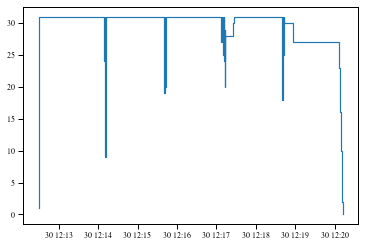

In [106]:
plt.step(util_t, util_c, where="post")

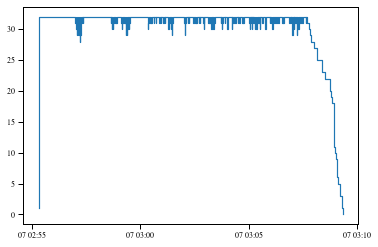

In [107]:
jqs = Job.objects.filter(state="JOB_FINISHED", tags= {"size": "L", "num_nodes": "32", "experiment": "eig-scaling-cori1", "job_source": "aps_dtn"})
qs = EventLog.objects.filter(job_id=[j.id for j in jqs])
util_t, util_c = utilization_report(qs)
plt.step(util_t, util_c, where="post")

Cori 4s 6.612423701706358
Cori 16l 7.90475915007311
Cori 8s 14.471354568313346
Cori 4c 3.0969362092666697
Cori 8c 6.469196596943822
Cori 32s 32.21106772286957
Cori 32c 18.77561847561521
Cori 32l 13.739098296824809
Cori 32s-run2 37.425370361674176
Cori 16s 20.41754373690643
Cori 4l 1.8675882862092437
Cori 8l 4.5883674096549765
Cori 16c 9.708300395379421


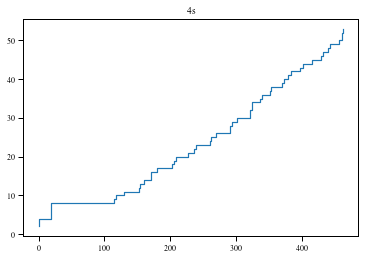

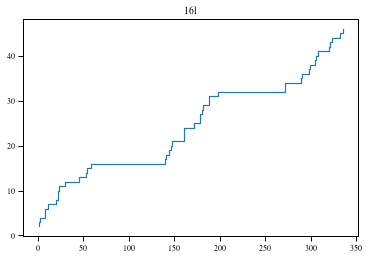

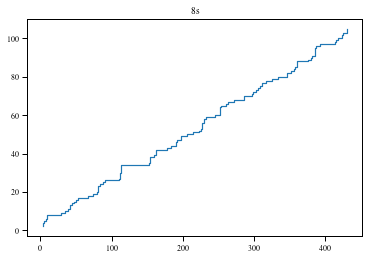

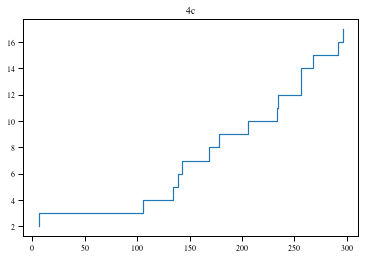

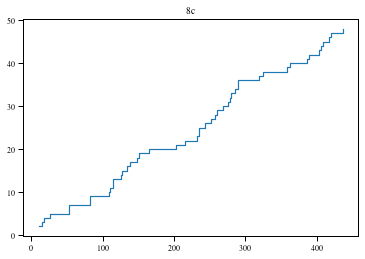

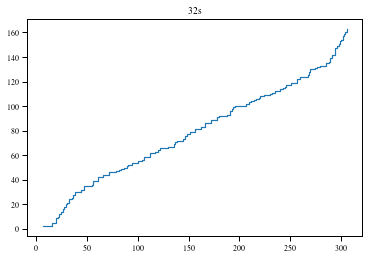

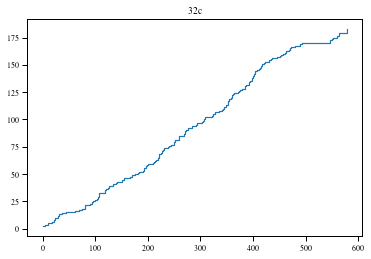

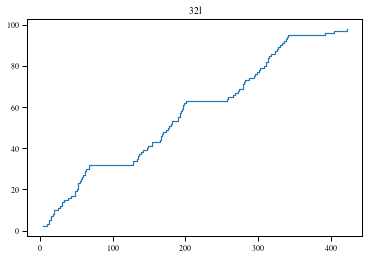

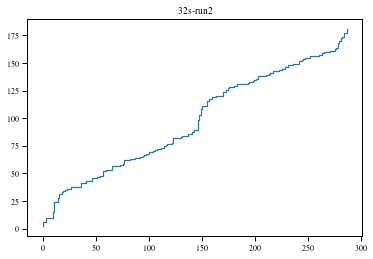

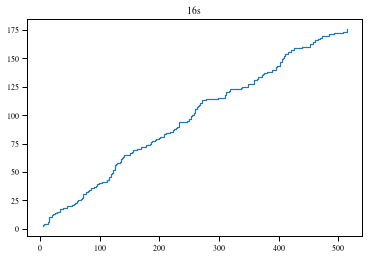

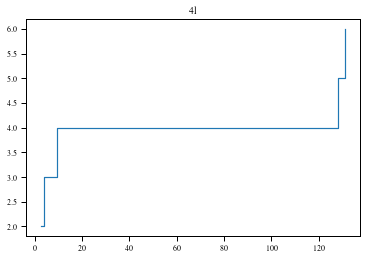

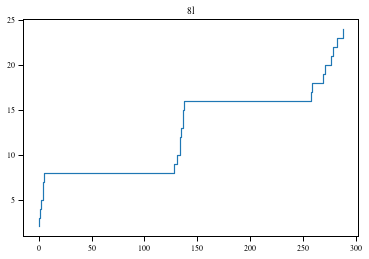

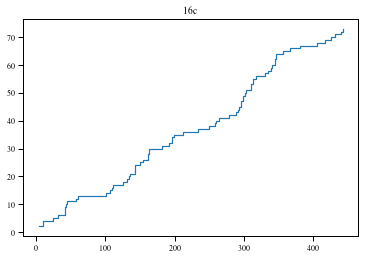

In [28]:
for key, dat in copied_out_times_cori.items():
    times = list(dat.values())
    t0 = min(times)
    times = sorted([(t-t0).total_seconds() for t in times])
    counts = list(range(1, len(times)+1))
    times = times[1:-8]
    counts = counts[1:-8]
    fig, ax = plt.subplots()
    ax.step(times, counts, where="post")
    ax.set_title(key)
    print("Cori", key, avg_jobs_per_min(times, counts))

4 6.106290483996444
8 11.397119449291187
16 22.93833831534746
32 48.16357783769716


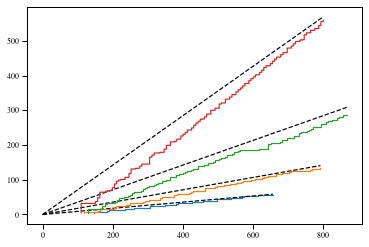

In [29]:
dat = balsam_throughput_by_nodes(tag_sets["S"], trim_head=5, trim_tail=30)
for num_nodes, (times, counts) in sorted(dat.items()):
    plt.step(times, counts, label=str(num_nodes), where="post")
    tgrid = np.linspace(0, max(times))
    ideal = num_nodes * tgrid / 45.0
    plt.plot(tgrid, ideal, 'k--')
    print(num_nodes, avg_jobs_per_min(times, counts))

4 4.4718596535666375
8 7.504950975783988
16 12.394428549365472
32 30.548068734464582


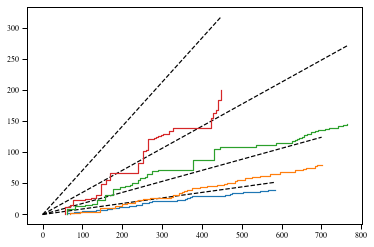

In [30]:
dat = balsam_throughput_by_nodes(tag_sets["C"], trim_head=1, trim_tail=19)
for num_nodes, (times, counts) in sorted(dat.items()):
    plt.step(times, counts, label=str(num_nodes), where="post")
    tgrid = np.linspace(0, max(times))
    ideal = num_nodes * tgrid / 45.0
    plt.plot(tgrid, ideal, 'k--')
    print(num_nodes, avg_jobs_per_min(times, counts))

In [164]:
dat = balsam_throughput_by_nodes(tag_sets["S"], trim_tail=30)
thru_balsamS = [avg_jobs_per_min(*dat[k]) for k in labels ]
dat = balsam_throughput_by_nodes(tag_sets["L"], trim_head=1, trim_tail=12)
thru_balsamL = [avg_jobs_per_min(*dat[k]) for k in labels ]
dat = balsam_throughput_by_nodes(tag_sets["C"], trim_head=1, trim_tail=19)
thru_balsamC = [avg_jobs_per_min(*dat[k]) for k in labels ]

In [165]:
sizes = ["S", "L", "C"]
ncounts = [4,8,16,32]
tag_sets_cori = {
    size: [
        {"size": size, "num_nodes": str(nnodes), "experiment": "eig-scaling-cori1"}
        for nnodes in ncounts
    ]
    for size in sizes
}
cori_eig_scaling = {}
for size, tag_set in tag_sets_cori.items():
    dat = balsam_throughput_by_nodes(tag_set, trim_head=1, trim_tail=5)
    cori_eig_scaling[size] = dat

4 15.971348456203511
8 32.257454578947836
16 59.55642243289059
32 111.32833940870655
4 2.3565307819369745
8 4.623033944527026
16 7.985674952442637
32 18.720201891852057
4 3.605329821348779
8 7.41700211195057
16 15.211644683023128
32 28.50955320640584


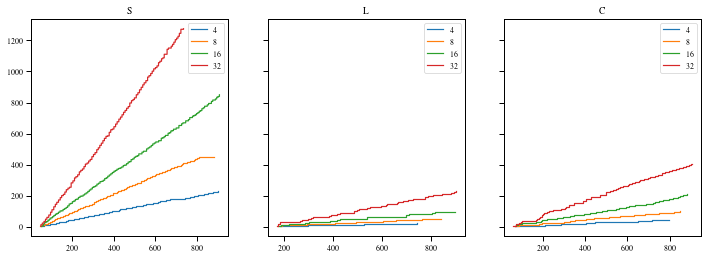

In [166]:
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(12,4))
cori_eig_thru = {}
for ax, (size, dat) in zip(axes, cori_eig_scaling.items()):
    tag_set = tag_sets_cori[size]
    ax.set_title(size)
    cori_eig_thru[size] = []
    for num_nodes, (times, counts) in sorted(dat.items()):  
        ax.step(times, counts, label=str(num_nodes), where="post")
        print(num_nodes, avg_jobs_per_min(times, counts))
        cori_eig_thru[size].append(avg_jobs_per_min(times, counts))
    ax.legend()

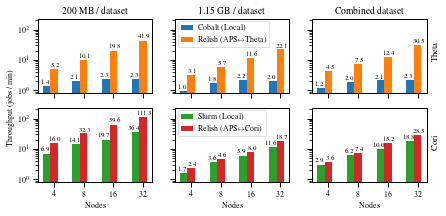

In [167]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(FULLWIDTH,3.0))


with plt.rc_context(rc={
    "legend.handlelength":1.5, 
    #"legend.labelspacing":0.25, 
    #"legend.borderpad": 0.2, 
    "legend.handletextpad": 0.55, 
    #"legend.columnspacing": 1.1, 
    #"legend.borderaxespad": 1.0
}):
    multi_barplot(axes[0,0], labels, None, thru_clusterS, thru_balsamS, height_labels=None, fontsize=7)
    axes[0,0].set_title('200 MB / dataset')
    axes[0,0].set_ylim(0,50)
    
    multi_barplot(axes[0,1], labels, ["Cobalt (Local)", "Relish (APS$\\leftrightarrow$Theta)"], thru_clusterL, thru_balsamL, height_labels=None, fontsize=7)
    axes[0,1].set_title('1.15 GB / dataset')
    move_legend(axes[0,1], new_loc=(0.03, 0.62))
    axes[0,1].set_ylim(0, 28)

    multi_barplot(axes[0,2], labels, None, thru_clusterC, thru_balsamC, height_labels=None, fontsize=7)
    axes[0,2].set_title('Combined dataset')
    axes[0,2].set_ylim(0, 38)

    multi_barplot(axes[1,0], labels, None, thru_cluster_coriS, cori_eig_thru["S"], color_offset=2, fontsize=7)
    axes[1,0].set_ylim(0, 130)

    multi_barplot(axes[1,1], labels, ["Slurm (Local)", "Relish (APS$\\leftrightarrow$Cori)"], thru_cluster_coriL, cori_eig_thru["L"], color_offset=2, fontsize=7)
    move_legend(axes[1,1], new_loc=(0.03, 0.62))
    axes[1,1].set_ylim(0, 24)

    multi_barplot(axes[1,2], labels, None, thru_cluster_coriC, cori_eig_thru["C"], color_offset=2, fontsize=7)
    axes[1,2].set_ylim(0, 36)

    for ax in axes.flatten():
        ax.set_yscale('log')
        ax.set_ylim(0.8, 220)

axes[1,0].set_ylabel('Throughput (jobs / min)', y=1.0)
for col in range(3):
    axes[1,col].set_xlabel("Nodes")
    
axes[0,2].text(3.45, 10.0, "Theta", rotation=90, fontsize=9)
axes[1,2].text(3.45, 10.0, "Cori", rotation=90, fontsize=9)

plt.savefig("figures/throughput_eig_log.pdf", bbox_inches="tight")

In [168]:
def cluster_pipeline_df(size):
    assert size in ['S', 'L', 'C']
    cluster_submit_times = {k:v for run_dict in submit_times.values() for k,v in run_dict.items() }
    cluster_start_times = {k:v for d in job_start_times.values() for k,v in d.items()}
    cluster_stagein_times = {k:v for d in  copied_in_times.values() for k,v in d.items()}
    cluster_done_times = {k:v for d in  app_done_times.values() for k,v in d.items()}
    cluster_stageout_times = {k:v for d in  copied_out_times.values() for k,v in d.items()}
    common_keys = [k for k in cluster_submit_times.keys() & cluster_stageout_times.keys()]
    common_keys = [k for k in common_keys if size in k.as_posix()]
    t_queueing = []
    t_stagein = []
    t_run = []
    t_stageout = []
    for k in common_keys:
        t_queueing.append( cluster_start_times[k] - cluster_submit_times[k] )
        t_stagein.append( cluster_stagein_times[k] - cluster_start_times[k] )
        t_run.append( cluster_done_times[k] - cluster_stagein_times[k] )
        t_stageout.append( cluster_stageout_times[k] - cluster_done_times[k] )

    t_queueing = [t.total_seconds() for t in t_queueing]
    t_stagein = [t.total_seconds() for t in t_stagein]
    t_run = [t.total_seconds() for t in t_run]
    t_stageout = [t.total_seconds() for t in t_stageout]
    t_total = [(cluster_stageout_times[k] - cluster_submit_times[k]).total_seconds() for k in common_keys]
    dat = pd.DataFrame({"Queueing": t_queueing, "Stage In": t_stagein, "Run": t_run, "Stage Out": t_stageout, "Total": t_total})
    return dat

def cluster_pipeline_df_cori(size):
    assert size in ['S', 'L', 'C']
    cluster_submit_times = {k:v for run_dict in submit_times_cori.values() for k,v in run_dict.items() }
    cluster_start_times = {k:v for d in job_start_times_cori.values() for k,v in d.items()}
    cluster_stagein_times = {k:v for d in  copied_in_times_cori.values() for k,v in d.items()}
    cluster_done_times = {k:v for d in  app_done_times_cori.values() for k,v in d.items()}
    cluster_stageout_times = {k:v for d in  copied_out_times_cori.values() for k,v in d.items()}
    common_keys = [k for k in cluster_submit_times.keys() & cluster_stageout_times.keys()]
    common_keys = [k for k in common_keys if size in k.as_posix()]
    t_queueing = []
    t_stagein = []
    t_run = []
    t_stageout = []
    for k in common_keys:
        t_queueing.append( cluster_start_times[k] - cluster_submit_times[k] )
        t_stagein.append( cluster_stagein_times[k] - cluster_start_times[k] )
        t_run.append( cluster_done_times[k] - cluster_stagein_times[k] )
        t_stageout.append( cluster_stageout_times[k] - cluster_done_times[k] )

    t_queueing = [t.total_seconds() for t in t_queueing]
    t_stagein = [t.total_seconds() for t in t_stagein]
    t_run = [t.total_seconds() for t in t_run]
    t_stageout = [t.total_seconds() for t in t_stageout]
    t_total = [(cluster_stageout_times[k] - cluster_submit_times[k]).total_seconds() for k in common_keys]
    dat = pd.DataFrame({"Queueing": t_queueing, "Stage In": t_stagein, "Run": t_run, "Stage Out": t_stageout, "Total": t_total})
    return dat

In [169]:
tag_sets = {
    "L": [
      {"size": "L", "num_nodes": "32", "experiment": "eig-scaling-theta1", "job_source": "aps_dtn"},
      {"size": "L", "num_nodes": "8", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
      {"size": "L", "num_nodes": "16", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
      {"size": "L", "num_nodes": "4", "experiment": "eig-scaling-theta3", "job_source": "aps_dtn"},
    ],
    "S": [
      {"size": "S", "num_nodes": "32", "experiment": "eig-scaling-theta1", "job_source": "aps_dtn"},
      {"size": "S", "num_nodes": "4", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"}, # or eig-scaling-theta3
      {"size": "S", "num_nodes": "16", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
      {"size": "S", "num_nodes": "8", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
   ],
    "C": [
      {"size": "C", "num_nodes": "4", "experiment": "eig-scaling-theta3", "job_source": "aps_dtn"},
      {"size": "C", "num_nodes": "16", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
      {"size": "C", "num_nodes": "32", "experiment": "eig-scaling-theta1", "job_source": "aps_dtn"},
      {"size": "C", "num_nodes": "8", "experiment": "eig-scaling-theta2", "job_source": "aps_dtn"},
   ]
}

dat_clusterS = cluster_pipeline_df("S")
dat_clusterL = cluster_pipeline_df("L")
dat_clusterC = cluster_pipeline_df("C")

dat_slurmS = cluster_pipeline_df_cori("S")
dat_slurmL = cluster_pipeline_df_cori("L")
dat_slurmC = cluster_pipeline_df_cori("C")

dat_balsamS = balsam_pipeline_df(tag_sets["S"])
dat_balsamL = balsam_pipeline_df(tag_sets["L"])
dat_balsamC = balsam_pipeline_df(tag_sets["C"])
dat_balsam_coriS = balsam_pipeline_df([{"experiment": "eig-scaling-cori1", "size": "S"}])

In [170]:
dat_balsam_coriL = balsam_pipeline_df([{"experiment": "eig-scaling-cori1", "size": "L"}])
dat_balsam_coriC = balsam_pipeline_df([{"experiment": "eig-scaling-cori1", "size": "C"}])

In [171]:
dat_slurmS = cluster_pipeline_df_cori("S")
dat_slurmL = cluster_pipeline_df_cori("L")
dat_slurmC = cluster_pipeline_df_cori("C")

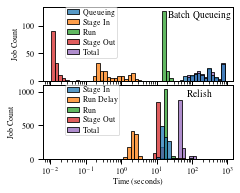

In [172]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(COLWIDTH,2.8), gridspec_kw={"wspace": 0.025, "hspace": 0.05})

#sns.kdeplot(data=dat, log_scale=True, fill=True, common_norm=False, gridsize=2000, bw_adjust=0.8, cut=2.0, ax=axes[0], legend=True)
ax = sns.histplot(data=dat_clusterS, log_scale=True, fill=True, common_norm=False, ax=axes[0], legend=True, bins=50)

with plt.rc_context(rc={
    "legend.handlelength":1.5, 
    "legend.labelspacing":0.25, 
    "legend.borderpad": 0.2, 
    "legend.handletextpad": 0.55, 
    "legend.columnspacing": 1.1, 
    "legend.borderaxespad": 1.0
}):
    move_legend(axes[0], (0.12, 0.32))
    sns.histplot(data=dat_balsamS, log_scale=True, fill=True, common_norm=False, ax=axes[1], legend=True, bins=20)
    move_legend(axes[1], (0.12, 0.32))
    
axes[0].set_title("Batch Queueing", y=0.85, x=0.82, pad=0)
axes[1].set_title("Relish", y=0.85, x=0.82, pad=0)
axes[1].set_xlabel("Time (seconds)")
axes[0].set_ylabel("Job Count")
axes[1].set_ylabel("Job Count")
plt.savefig("figures/queue_vs_balsam_hist.pdf", bbox_inches="tight")
#ax.set_xlim(0, 200)

In [117]:
dat_slurmS.median()


Queueing      2.703736
Stage In      0.374344
Run          11.787164
Stage Out     0.037271
Total        15.041308
dtype: float64

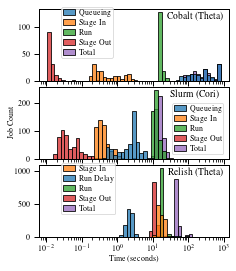

In [173]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(COLWIDTH,4.2), gridspec_kw={"wspace": 0.025, "hspace": 0.08})

#sns.kdeplot(data=dat, log_scale=True, fill=True, common_norm=False, gridsize=2000, bw_adjust=0.8, cut=2.0, ax=axes[0], legend=True)
ax = sns.histplot(data=dat_clusterS, log_scale=True, fill=True, common_norm=False, ax=axes[0], legend=True, bins=50)

switched_palette = sns.color_palette()[:5]
switched_palette[1], switched_palette[0] = switched_palette[0], switched_palette[1]

with plt.rc_context(rc={
    "legend.handlelength":1.5, 
    "legend.labelspacing":0.25, 
    "legend.borderpad": 0.2, 
    "legend.handletextpad": 0.55, 
    "legend.columnspacing": 1.1, 
    "legend.borderaxespad": 1.0,
}):
    move_legend(axes[0], (0.12, 0.32), ncol=1)
    
    sns.histplot(data=dat_slurmS, log_scale=True, fill=True, common_norm=False, ax=axes[1], legend=True, bins=40)
    move_legend(axes[1], (0.7, 0.07), ncol=1)
    #move_legend(axes[1], (0.12, 0.32), ncol=1)
    
    sns.histplot(data=dat_balsamS, log_scale=True, fill=True, common_norm=False, ax=axes[2], legend=True, bins=20, palette=switched_palette)
    move_legend(axes[2], (0.12, 0.32), ncol=1)

    
axes[0].set_title("Cobalt (Theta)", y=0.85, x=0.82, pad=0)
axes[1].set_title("Slurm (Cori)", y=0.85, x=0.82, pad=0)
axes[2].set_title("Relish (Theta)", y=0.85, x=0.82, pad=0)

axes[2].set_xlabel("Time (seconds)")
axes[1].set_ylabel("Job Count")
axes[0].set_ylabel(None)
axes[2].set_ylabel(None)
#axes[1].set_ylabel("Job Count")
plt.savefig("figures/queue_vs_balsam_hist_with_cori.pdf", bbox_inches="tight")
#ax.set_xlim(0, 200)

In [108]:

#ax = sns.histplot(data=dat_slurmS, log_scale=True, fill=True, common_norm=False, legend=True, bins=20, palette=switched_palette)
dat_balsamS.median()

Stage In     16.056427
Run Delay     2.274045
Run          16.790566
Stage Out    11.560311
Total        47.637630
dtype: float64

In [50]:
dat = defaultdict(dict)
dat["Cluster"]["S"] = dat_clusterS
dat["Cluster"]["L"] = dat_clusterL
dat["Cluster"]["C"] = dat_clusterC
dat["Balsam"]["S"] = dat_balsamS
dat["Balsam"]["L"] = dat_balsamL
dat["Balsam"]["C"] = dat_balsamC

summary = defaultdict(lambda: defaultdict(dict))
for exp in dat:
    for size, df in dat[exp].items():
        df["Overhead"] = df["Total"] - df["Run"]
        #print(exp, size)
        for k in df:
            mean, std, hi = df[k].mean(), df[k].std(), df[k].quantile(0.95)
            summary[exp][size][k] = f"{mean:.1f} pm {std:.1f} ({hi:.1f})"

In [59]:
s = pd.DataFrame(summary["Cluster"]).to_latex()
print(s.replace("pm", "\pm").replace("(", "\ ("))
dat["Cluster"]["C"]

\begin{tabular}{llll}
\toprule
{} &                       S &                       L &                       C \\
\midrule
Queueing  &  328.9 \pm 249.2 \ (782.8) &  198.7 \pm 144.5 \ (533.7) &  278.8 \pm 199.6 \ (709.5) \\
Stage In  &        0.8 \pm 0.8 \ (2.3) &       5.5 \pm 5.2 \ (14.1) &       3.5 \pm 4.9 \ (15.3) \\
Run       &      17.5 \pm 2.0 \ (21.7) &      89.3 \pm 7.6 \ (94.0) &     55.1 \pm 35.5 \ (89.8) \\
Stage Out &        0.0 \pm 0.1 \ (0.1) &        0.0 \pm 0.1 \ (0.1) &        0.0 \pm 0.0 \ (0.0) \\
Total     &  347.2 \pm 248.6 \ (799.8) &  293.5 \pm 147.4 \ (622.1) &  337.4 \pm 204.1 \ (767.4) \\
Overhead  &  329.8 \pm 249.2 \ (783.2) &  204.2 \pm 144.3 \ (535.3) &  282.3 \pm 199.6 \ (714.5) \\
\bottomrule
\end{tabular}



,Queueing,Stage In,Run,Stage Out,Total,Overhead
0,125.035960,2.081310,87.225523,0.041001,214.383794,127.158271
1,83.571511,21.063831,89.211869,0.012580,193.859791,104.647922
2,178.619385,0.216065,17.434815,0.012147,196.282412,178.847597
3,233.842031,10.408290,86.159183,0.012012,330.421516,244.262333
4,281.890513,0.415828,16.952124,0.018772,299.277237,282.325113
...,...,...,...,...,...,...
113,156.817387,2.127170,87.502474,0.013281,246.460312,158.957838
114,56.383830,1.483406,22.800142,0.011641,80.679019,57.878877
115,159.237473,0.675235,17.914345,0.011791,177.838844,159.924499
116,534.917412,4.384373,88.453615,0.012792,627.768192,539.314577


# Eig: backlog tests (APS->Theta)

In [121]:
tags = {"experiment": "eig-backlog-theta1", "job_source": "aps_dtn"}
finished_jobs = Job.objects.filter(tags=tags, state="JOB_FINISHED")
finished_ids = [j.id for j in finished_jobs]   
events = EventLog.objects.filter(job_id=finished_ids)

created_t, created_c = throughput_report(events, to_state="READY")
stagedin_t, stagedin_c = throughput_report(events, to_state="STAGED_IN")
done_t, done_c = throughput_report(events, to_state="RUN_DONE")
finish_t, finish_c = throughput_report(events, to_state="JOB_FINISHED")
backlog_t = sorted(created_t + finish_t)
t0 = min(created_t)
created_t = [(t - t0).total_seconds() / 60 for t in created_t]
finish_t = [(t - t0).total_seconds() / 60 for t in finish_t]
done_t = [(t - t0).total_seconds() / 60 for t in done_t]
stagedin_t =  [(t - t0).total_seconds() / 60 for t in stagedin_t]

created_t.extend(np.linspace(max(created_t), max(finish_t), num=50))
stagedin_t.extend(np.linspace(max(created_t), max(finish_t), num=50))
created_c.extend(max(created_c) for _ in range(50))
stagedin_c.extend(max(stagedin_c) for _ in range(50))

util_t, util_c = utilization_report(events, node_weighting=True)
start_t = min(util_t) - timedelta(minutes=5)
end_t = max(util_t) + timedelta(minutes=5)
batchjobs = BatchJob.objects.filter(start_time_after=start_t, end_time_before=end_t)
avail_t, avail_c = available_nodes(batchjobs)

In [122]:
backlog_c = []
for time_created, count_created in zip(created_t, created_c):
    idx_finished = min((abs(time_finished-time_created), idx) for idx, time_finished in enumerate(finish_t))[1]
    backlog_c.append(count_created - finish_c[idx_finished])

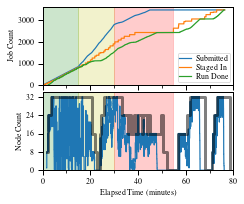

In [125]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(COLWIDTH,3), gridspec_kw={"wspace": 0.025, "hspace": 0.09})

for i in (0,1):
    axes[i].axvspan(0, 15, color='g', alpha=0.2)
    axes[i].axvspan(15, 30, color='y', alpha=0.2)
    axes[i].axvspan(30, 54.5, color='r', alpha=0.2)

axes[0].step(created_t, created_c, where="post", label="Submitted")
axes[0].step(stagedin_t, stagedin_c, where="post", label="Staged In")
axes[0].step(done_t, done_c, where="post", label="Run Done")
#axes[0].step(finish_t, finish_c, where="post", label="Staged Out")

axes[0].set_xlim(0, 80)
axes[0].set_ylim(0, 3600)
with plt.rc_context(rc={
    "legend.handlelength":1.5, 
    "legend.labelspacing":0.1, 
    "legend.borderpad": 0.2, 
    "legend.handletextpad": 0.55, 
    "legend.columnspacing": 1.1, 
    "legend.borderaxespad": 0.4
}):
    axes[0].legend(loc="lower right")
axes[0].set_ylabel("Job Count")
axes[1].xaxis.set_minor_locator(MultipleLocator(10))

axes[1].step([(t - t0).total_seconds() / 60 for t in util_t], util_c, where="post")
axes[1].step([(t - t0).total_seconds() / 60 for t in avail_t], avail_c, alpha=0.5, c='k', lw=3, where="post")
axes[1].set_xlabel("Elapsed Time (minutes)")
axes[1].set_ylabel("Node Count")
axes[1].set_ylim(0, 34)
axes[1].set_yticks([8*i for i in range(5)])
plt.savefig("figures/backlog.pdf", bbox_inches="tight")


# IO Batching

In [411]:
io_thru = defaultdict(dict)
for bs in (8, 16,32,64,128):
    for size in ("S", "L"):
        jobs = Job.objects.filter(tags={"experiment": "io-test2", "bs": bs, "size": size}, state="JOB_FINISHED")
        job_ids = [j.id for j in jobs]
        qs = EventLog.objects.filter(job_id=job_ids)
        t0 = min([e.timestamp for e in EventLog.objects.filter(job_id=job_ids, from_state="CREATED")])
        times, counts = throughput_report(qs, to_state="STAGED_IN")
        tf = max(times)
        c = max(counts)
        assert c == 128
        jps = c / (tf - t0).total_seconds()
        io_thru[size][bs] = jps
        
jobs = Job.objects.filter(tags={"experiment": "io-test3", "bs": 16, "size": "S"}, state="JOB_FINISHED")
job_ids = [j.id for j in jobs]
qs = EventLog.objects.filter(job_id=job_ids)
t0 = min([e.timestamp for e in EventLog.objects.filter(job_id=job_ids, from_state="CREATED")])
times, counts = throughput_report(qs, to_state="STAGED_IN")
tf = max(times)
c = max(counts)
assert c == 128
jps = c / (tf - t0).total_seconds()
io_thru["S"][16] = jps

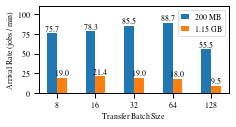

In [414]:
labels = [8, 16, 32, 64, 128]
sizes = ["S", "L"]

fig, ax = plt.subplots(figsize=(COLWIDTH, 1.6))
dat_small = [60*io_thru["S"][k] for k in labels]
dat_large = [60*io_thru["L"][k] for k in labels]

with plt.rc_context({"legend.handlelength": 1}):
    multi_barplot(ax, labels, ["200 MB", "1.15 GB"], dat_small, dat_large, height_labels=None)
    ax.set_xlabel("Transfer Batch Size")
    ax.set_ylabel('Arrival Rate (jobs / min)')
    ax.set_ylim(0,110)
    plt.savefig("figures/transfer-batch.pdf", bbox_inches="tight")

In [154]:
import json
with open("data/globus-history2.json") as fp:
    globus_dat = json.load(fp)

('aps#lcfsys1', 'NERSC Cori') 68
('aps#lcfsys1', 'alcf#dtn_theta') 213
('aps#lcfsys1', 'OLCF DTN') 109
('alsuser#data832', 'alcf#dtn_theta') 22
('alsuser#data832', 'OLCF DTN') 19
('alsuser#data832', 'NERSC Cori') 25
('aps#lcfsys1', 'alcf#dtn_theta') 196.5 +/- 166.8 MB/sec min 35.534144 max 986.555984
('aps#lcfsys1', 'OLCF DTN') 360.4 +/- 276.0 MB/sec min 23.894206 max 1169.505503
('aps#lcfsys1', 'NERSC Cori') 311.4 +/- 210.4 MB/sec min 32.595445 max 802.451219
('alsuser#data832', 'alcf#dtn_theta') 107.4 +/- 28.8 MB/sec min 37.680237 max 163.704751
('alsuser#data832', 'OLCF DTN') 277.5 +/- 138.1 MB/sec min 80.62831 max 602.411666
('alsuser#data832', 'NERSC Cori') 282.6 +/- 155.3 MB/sec min 89.528984 max 648.084369


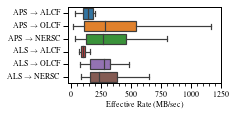

In [156]:
globus_tasks = globus_dat['DATA']
done_transfers = [t for t in globus_tasks if t['status'] == 'SUCCEEDED' and t['bytes_transferred'] > 1e10]
transfers =  defaultdict(list)
for t in done_transfers:
    key = (t["source_endpoint_display_name"], t["destination_endpoint_display_name"])
    transfers[key].append(t["effective_bytes_per_second"]/1e6)
for key in transfers:
    print(key, len(transfers[key]))
keys = [
    ('aps#lcfsys1', 'alcf#dtn_theta'),
    ('aps#lcfsys1', 'OLCF DTN'),
    ('aps#lcfsys1', 'NERSC Cori'),
    
    ('alsuser#data832', 'alcf#dtn_theta'),
    ('alsuser#data832', 'OLCF DTN'),
    ('alsuser#data832', 'NERSC Cori'),
]
labels = [
    r"APS $\rightarrow$ ALCF",
    r"APS $\rightarrow$ OLCF",
    r"APS $\rightarrow$ NERSC",
    r"ALS $\rightarrow$ ALCF",
    r"ALS $\rightarrow$ OLCF",
    r"ALS $\rightarrow$ NERSC",
]
for key in keys:
    dat = np.array(transfers[key])
    mean, std = dat.mean(), dat.std()
    print(key, f"{mean:.1f} +/- {std:.1f} MB/sec", "min", dat.min(), "max", dat.max())# , len(dat))

#mpl.use("pdf")
fig, ax = plt.subplots(figsize=(COLWIDTH*0.8, 1.4))
sns.boxplot(data=[transfers[k] for k in keys], orient="h", fliersize=0.0, whis=1.5, ax=ax)
ax.set_yticklabels(labels)
ax.set_xticks([0,250,500,750,1000,1250])
ax.set_xlim(-20,1250)
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_xlabel("Effective Rate (MB/sec)")
plt.savefig("figures/globus.pdf", bbox_inches="tight")

## Arrival Rate
- Staging in for 128 jobs
- Up to 3 concurrent Globus transfers
- Varying # files per transfer task (batch size)
- Syncing TransferTasks with API every 5 seconds
- For 200 MB file, peak arrival rate is around 64 BS (12.8 GB batch)
- For 1.1 GB file, peak arrival rate is around 16 BS (17.6 GB batch)
- Latency ammortized by higher batch size
- But, with higher batch size, concurrency drops:
- only 2 concurrent transfers at BS 64; only 1 transfer at BS 128
- And with higher batch size, higher per-job latency
- Sweet spot around 15 GB batch for APS-->ALCF with 200 MB/sec effective transfer rate

# XPCS Tests

In [93]:
events_theta = EventLog.objects.filter(
    job_id=[j.id for j in Job.objects.filter(tags={"experiment": "xpcs-theta1"}, state="JOB_FINISHED")]
)
events_cori = EventLog.objects.filter(
    job_id=[j.id for j in Job.objects.filter(tags={"experiment": "xpcs-cori1"}, state="JOB_FINISHED")]
)
events_summit = EventLog.objects.filter(
    job_id=[j.id for j in Job.objects.filter(tags={"experiment": "xpcs-summit-test"}, state="JOB_FINISHED")]
)

In [94]:
thru_theta  = throughput_report(events_theta)
thru_cori = throughput_report(events_cori)
thru_summit = throughput_report(events_summit)

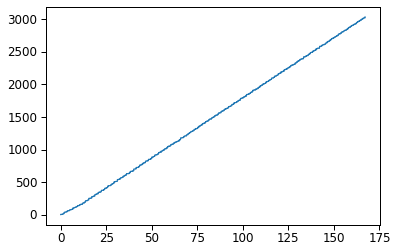

In [111]:
def elapsed_min(times):
    return np.array([(t - min(times)).total_seconds() for t in times]) / 60

plt.step(elapsed_min(thru_theta[0]), thru_theta[1], where="post")

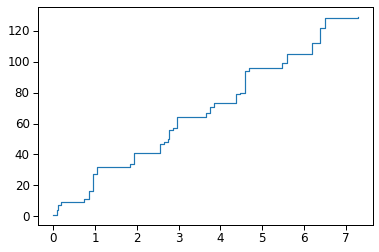

In [112]:
plt.step(elapsed_min(thru_summit[0]), thru_summit[1], where="post")

(0.0, 180.0)

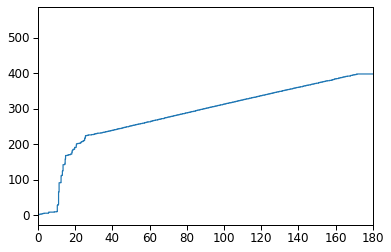

In [122]:
plt.step(elapsed_min(thru_cori[0]), thru_cori[1], where="post")
plt.gca().set_xlim(0, 180)

In [127]:
#    6       xpcs.EigenCorr   thetalogin4:/gpfs/mira-home/msalim/balsam/test-sites/test
#   14       xpcs.EigenCorr   cori03:/global/project/projectdirs/m3676/msalim/b2sites/test
#    7       xpcs.EigenCorr   thetalogin4:/lus/theta-fs0/projects/datascience/msalim/b2sites/test
#   19       xpcs.EigenCorr   thetalogin6:/lus/theta-fs0/projects/WorkExpFacil/msalim/sc21
#   25       xpcs.EigenCorr   login2:/gpfs/alpine/csc435/proj-shared/msalim/testsite
#   22       xpcs.EigenCorr   login4:/gpfs/alpine/csc435/proj-shared/msalim/sc21-site
#   27       xpcs.EigenCorr   thetalogin5:/lus/theta-fs0/projects/WorkExpFacil/msalim/io-test

def experiment_iter(exp_tag):
    app_ids = [19, 14, 22] # theta, cori, summit
    #app_to_sitename = {19: "Theta", 14: "Cori", 22: "Summit"}
    app_to_sitename = {19: "Theta", 22: "Summit", 14: "Cori"}
    sourcemap = {"aps_dtn": "APS", "als_dtn": "ALS"}
    result = {}
    for source in ["aps_dtn", "als_dtn"]:
        for app_id in app_ids:
            job_qs = Job.objects.filter(app_id=app_id, tags={"experiment": exp_tag, "job_source": source}, state="JOB_FINISHED")
            if job_qs.count() > 0:
                yield (sourcemap[source], app_to_sitename[app_id]), job_qs

latencies = {}
for key, job_qs in experiment_iter("latency1"):
    df = job_qs_to_pipeline_df(job_qs)
    print(key, df["Total"].min(), df["Total"].max())
    latencies[key] = {}
    for stage in df.keys():
        latencies[key][stage] = df[stage].median()

('APS', 'Theta') 136.752435 143.205893
('APS', 'Cori') 85.734448 110.502407
('APS', 'Summit') 129.561581 140.836874
('ALS', 'Theta') 143.53784 150.113213
('ALS', 'Cori') 95.034248 142.274033
('ALS', 'Summit') 134.487583 143.167568


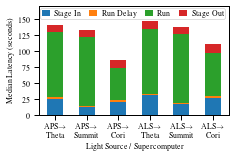

In [10]:
def stacked_bars(data, labels, ax, width=0.5):
    keys = list(data.keys())
    x = np.arange(len(keys))
    bottoms = np.zeros(x.shape)
    for label in labels:
        y = np.array([data[k][label] for k in keys])
        ax.bar(x, y, width, label=label, bottom=bottoms)
        bottoms += y
    ax.set_xticks(x)

fig, ax = plt.subplots(figsize=(COLWIDTH, 2.0))
stages = ["Stage In", "Run Delay", "Run", "Stage Out"]

ordered_keys = [("APS", "Theta"), ("APS", "Summit"), ("APS", "Cori"), ("ALS", "Theta"), ("ALS", "Summit"), ("ALS", "Cori")]
latencies = {k: latencies[k] for k in ordered_keys}
stacked_bars(latencies, stages, ax)

ax.set_xticklabels([f"{k[0]}$\\rightarrow$\n{k[1]}" for k in ordered_keys])
ax.set_ylim(0,170)
ax.set_yticks([0,25,50,75,100,125,150])
ax.set_xlabel("Light Source / Supercomputer")
ax.set_ylabel("Median Latency (seconds)")
with plt.rc_context(rc={
    "legend.handlelength":1.0, 
    "legend.labelspacing":0.1, 
    "legend.borderpad": 0.2, 
    "legend.handletextpad": 0.55, 
    "legend.columnspacing": 1.1, 
    "legend.borderaxespad": 0.2
}):
    plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=4)
    plt.savefig("figures/latency.pdf", bbox_inches="tight")

In [131]:
for key in latencies: 
    #ovh = sum(latencies[key][k] for k in ["Stage In", "Run Delay", "Stage Out"])
    print(key, "run delay %:", latencies[key]["Run"], 100.0*latencies[key]["Run Delay"] / latencies[key]["Total"])

('APS', 'Theta') run delay %: 101.9793135 1.8576604945304394
('APS', 'Cori') run delay %: 50.762199 2.6337656884630394
('APS', 'Summit') run delay %: 107.47037 1.3718027541543265
('ALS', 'Theta') run delay %: 101.9760955 1.5776836305640158
('ALS', 'Cori') run delay %: 66.933642 2.383263721838783
('ALS', 'Summit') run delay %: 107.981906 1.5662130119476139


In [132]:
tags = {"APS": "aps-steady1", "ALS": "als-steady1", "APS+ALS": "both-steady1"}
steady_throughput = {}
for source, exp_tag in tags.items():
    for key, job_qs in experiment_iter(exp_tag):
        print(source, key[1], job_qs.count())
        qs = EventLog.objects.filter(job_id=[j.id for j in job_qs])
        times, counts = throughput_report(qs, to_state="JOB_FINISHED")
        entry = (source, key[1])
        if entry in steady_throughput:
            steady_throughput[entry].extend(times)
        else:
            steady_throughput[entry] = times

APS Theta 240
APS Cori 489
APS Summit 320
ALS Theta 176
ALS Cori 396
ALS Summit 293
APS+ALS Theta 97
APS+ALS Cori 125
APS+ALS Summit 113
APS+ALS Theta 99
APS+ALS Cori 91
APS+ALS Summit 105


In [133]:
steady_preprocessed = {}
steady_done = {}

for source, exp_tag in tags.items():
    for key, job_qs in experiment_iter(exp_tag):
        print(source, key[1], job_qs.count())
        qs = EventLog.objects.filter(job_id=[j.id for j in job_qs])
        times, counts = throughput_report(qs, to_state="PREPROCESSED")
        entry = (source, key[1])
        if entry in steady_preprocessed:
            steady_preprocessed[entry].extend(times)
        else:
            steady_preprocessed[entry] = times
            
        times, counts = throughput_report(qs, to_state="RUN_DONE")
        if entry in steady_done:
            steady_done[entry].extend(times)
        else:
            steady_done[entry] = times

APS Theta 240
APS Cori 489
APS Summit 320
ALS Theta 176
ALS Cori 396
ALS Summit 293
APS+ALS Theta 97
APS+ALS Cori 125
APS+ALS Summit 113
APS+ALS Theta 99
APS+ALS Cori 91
APS+ALS Summit 105


In [14]:
steady_utilization = {}
for source, exp_tag in tags.items():
    if "both" in exp_tag: continue
    for key, job_qs in experiment_iter(exp_tag):
        print(source, key[1], job_qs.count())
        qs = EventLog.objects.filter(job_id=[j.id for j in job_qs])
        steady_utilization[(source, key[1])] = utilization_report(qs)
        
steady_utilization = {k: steady_utilization[k] for k in ordered_keys}

APS Theta 240
APS Cori 489
APS Summit 320
ALS Theta 176
ALS Cori 396
ALS Summit 293


APS Theta 240 Arrival Rate: 15.998270960202191
APS Cori 489 Arrival Rate: 29.64105584544443
APS Summit 320 Arrival Rate: 19.630757576076544
ALS Theta 176 Arrival Rate: 12.371242529865066
ALS Cori 396 Arrival Rate: 24.198248255200124
ALS Summit 293 Arrival Rate: 17.93759508832159
APS+ALS Theta 196 Arrival Rate: 15.298169797992584
APS+ALS Cori 216 Arrival Rate: 18.063673571243392
APS+ALS Summit 218 Arrival Rate: 17.099752297929882


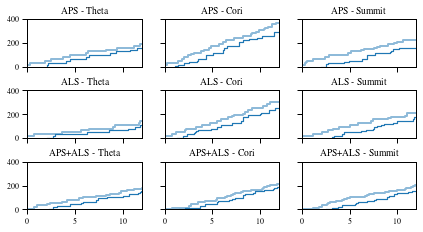

In [134]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(FULLWIDTH,3.5), gridspec_kw={"wspace": 0.2, "hspace": 0.5})

arrival_rates = {}

for ax, (key, data) in zip(axes.flatten(), steady_throughput.items()):
    source, site = key
    times = data
    times_pre = steady_preprocessed[key]
    t0 = min(times_pre)
    times = sorted([(t - t0).total_seconds()/60.0 for t in times])
    times_pre = sorted([(t - t0).total_seconds()/60.0 for t in times_pre])
    counts = list(range(1, len(times)+1))
    counts_pre = list(range(1, len(times_pre)+1))
    ax.step(times_pre, counts_pre, where="post", alpha=0.5, lw=2, c=sns.color_palette()[0])
    ax.step(times, counts, where="post", c=sns.color_palette()[0])
    

    print(source,site,max(counts), "Arrival Rate:", max(counts_pre)/max(times_pre))
    arrival_rates[key] = max(counts_pre) / max(times_pre)
    ax.set_title(f"{source} - {site}")
    ax.set_yticks([0, 200, 400])
    ax.set_xlim(0,12)
    ax.set_ylim(0, 400)
plt.savefig("figures/steady.pdf", bbox_inches="tight")

APS Theta 240 jobs done 16.9306527 minutes
APS Summit 320 jobs done 18.691343 minutes
APS Cori 489 jobs done 18.264313416666667 minutes
ALS Theta 176 jobs done 16.311168266666666 minutes
ALS Summit 293 jobs done 18.643407783333334 minutes
ALS Cori 396 jobs done 17.766943166666668 minutes
APS+ALS Theta 196 jobs done 14.730709183333333 minutes
APS+ALS Summit 218 jobs done 15.309799966666667 minutes
APS+ALS Cori 216 jobs done 13.128901233333332 minutes


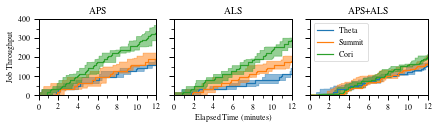

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(FULLWIDTH,1.4), gridspec_kw={"wspace": 0.15, "hspace": 0.5})


for ax, source in zip(axes,["APS", "ALS", "APS+ALS"]):
    for i, site in enumerate(["Theta", "Summit", "Cori"]):
        key = source, site
        times = steady_throughput[key]
        times_pre = steady_preprocessed[key]
        times_done = steady_done[key]
        t0 = min(times_pre)
        times = sorted([(t - t0).total_seconds()/60.0 for t in times])
        times_pre = sorted([(t - t0).total_seconds()/60.0 for t in times_pre])
        times_done = sorted([(t - t0).total_seconds()/60.0 for t in times_done])
        counts = list(range(1, len(times)+1))
        counts_pre = list(range(1, len(times_pre)+1))
        counts_done = list(range(1, len(times_done)+1))
        
        XX = np.linspace(0, 12, num=1500)
        Y_stagedout = [len([t for t in times if t<= X]) for X in XX]
        Y_pre = [len([t for t in times_pre if t<= X]) for X in XX]
        
        ax.fill_between(XX, Y_stagedout, Y_pre,  alpha=0.5, color=sns.color_palette()[i])
        print(source, site, max(counts), "jobs done", max(times), "minutes")
        
        #ax.step(times_pre, counts_pre, where="post", lw=2, ls='dashed', alpha=0.7, c=sns.color_palette()[i])
        #ax.step(times, counts, where="post", ls='dotted', lw=1, c=sns.color_palette()[i])#, label=site)
        ax.step(times_done, counts_done, where="post", c=sns.color_palette()[i], label=site)
    ax.set_title(source)
    ax.set_yticks([0, 100, 200, 300, 400])
    ax.set_xlim(0,12)
    ax.set_ylim(0, 400)
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(50))
    ax.set_xticks([0,2,4,6,8,10,12])
axes[2].legend(loc="upper left")
axes[1].set_xlabel("Elapsed Time (minutes)")
axes[0].set_ylabel("Job Throughput")
plt.savefig("figures/steady.pdf", bbox_inches="tight")

('APS', 'Theta') 84.97357758897944 76.23859587470719
('APS', 'Summit') 100.0 96.96488371900537
('APS', 'Cori') 78.36693621857101 76.67674080796301


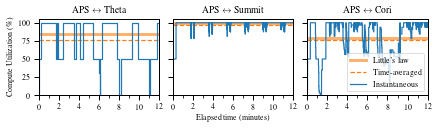

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(FULLWIDTH,1.4), gridspec_kw={"wspace": 0.12, "hspace": 0.5})
aps_util = {k:v for k,v in steady_utilization.items() if k[0] == "APS"}
for ax, (key, data) in zip(axes, aps_util.items()):
    times, utils = data
    t0 = min(times)
    times = [(t-t0).total_seconds()/60.0 for t in times]
    utils = [100*c/32 for c in utils]
    
    interval = max(times) - min(times)
    mean_util = 0.0
    for i in range(len(times)-1):
        mean_util += utils[i] * (times[i+1] - times[i]) / interval # Integrated time-average utilization
        
    theoretical_util = min(32, latencies[key]["Run"] * arrival_rates[key] / 60.0) # Little's Law
    theoretical_util *= (100/32)
    print(key, theoretical_util, mean_util)
    
    ax.axhline(theoretical_util, color=sns.color_palette()[1], lw=3, alpha=0.6, label="Little's law")
    ax.axhline(mean_util, color=sns.color_palette()[1], ls='--', label="Time-averaged")
    
    ax.step(times, utils, where="post", label="Instantaneous")
    ax.set_title(f"{key[0]} $\\leftrightarrow$ {key[1]}")
    ax.set_xlim(0,12)
    ax.set_ylim(0,105)
    ax.set_yticks([0,25,50,75,100])
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_xticks([0,2,4,6,8,10,12])

    
axes[1].set_xlabel("Elapsed time (minutes)")
axes[0].set_ylabel("Compute Utilization (\%)")
axes[2].legend(loc="lower right")
plt.savefig("figures/steady-util.pdf",bbox_inches="tight")

In [113]:
latencies

{('APS', 'Theta'): {'Stage In': 25.611160499999997,
  'Run Delay': 2.6133845,
  'Run': 101.9793135,
  'Stage Out': 10.189468000000002,
  'Total': 140.681492},
 ('APS', 'Cori'): {'Stage In': 20.835309,
  'Run Delay': 2.623206,
  'Run': 50.762199,
  'Stage Out': 11.416396,
  'Total': 99.599065},
 ('APS', 'Summit'): {'Stage In': 12.4501955,
  'Run Delay': 1.83361,
  'Run': 107.47037,
  'Stage Out': 11.718161,
  'Total': 133.66426},
 ('ALS', 'Theta'): {'Stage In': 30.9643005,
  'Run Delay': 2.3251185000000003,
  'Run': 101.9760955,
  'Stage Out': 11.272949,
  'Total': 147.37545949999998},
 ('ALS', 'Cori'): {'Stage In': 27.008646,
  'Run Delay': 2.600969,
  'Run': 66.933642,
  'Stage Out': 14.19746,
  'Total': 109.134754},
 ('ALS', 'Summit'): {'Stage In': 16.71549,
  'Run Delay': 2.157418,
  'Run': 107.981906,
  'Stage Out': 11.274843,
  'Total': 137.747419}}

In [120]:
101.979 * (15.998270960202191 / 60) # seconds * (jobs / second)

27.191461237507657

In [9]:
tags = {"Round Robin": "round-robin-fast1", "Shortest Backlog": "shortest-backlog1"}

ready = {}
preprocessed = {}
done = {}
finished = {}

for method, exp_tag in tags.items():
    for key, job_qs in experiment_iter(exp_tag):
        assert key[0] == "APS"
        site = key[1]
        print(method, site, job_qs.count())
        qs = EventLog.objects.filter(job_id=[j.id for j in job_qs])
        ready[(method, site)], _ = throughput_report(qs, to_state="READY")
        preprocessed[(method, site)], _ = throughput_report(qs, to_state="PREPROCESSED")
        done[(method, site)], _ = throughput_report(qs, to_state="RUN_DONE")
        finished[(method, site)], _ = throughput_report(qs, to_state="JOB_FINISHED")
        #entry = (source, key[1])
        #if entry in steady_throughput:
        #    steady_throughput[entry].extend(times)
        #else:
        #    steady_throughput[entry] = times

Round Robin Theta 240
Round Robin Cori 224
Round Robin Summit 224
Shortest Backlog Theta 256
Shortest Backlog Cori 272
Shortest Backlog Summit 288


Round Robin: Theta 15.23357763601629 jobs/min
Shortest Backlog: Theta 15.477041099282637 jobs/min
Round Robin: Summit 15.115918632058222 jobs/min
Shortest Backlog: Summit 16.332415157970843 jobs/min
Round Robin: Cori 15.963460076978537 jobs/min
Shortest Backlog: Cori 18.518629847155193 jobs/min
[15.23357763601629, 15.115918632058222, 15.963460076978537] [15.477041099282637, 16.332415157970843, 18.518629847155193]


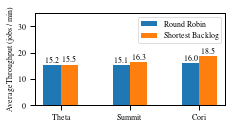

In [27]:
round_robin, shortest_backlog = [], []
labels = ["Theta", "Summit", "Cori"]
for site in labels:
    key = ("Round Robin", site)
    t0 = min(ready[key])
    finished_times = [(t-t0).total_seconds()/60 for t in finished[key]]
    print("Round Robin:", site, len(finished_times)/max(finished_times), "jobs/min")
    round_robin.append(len(finished_times)/max(finished_times))
   
    key = ("Shortest Backlog", site)
    t0 = min(ready[key])
    finished_times = [(t-t0).total_seconds()/60 for t in finished[key]]
    print("Shortest Backlog:", site, len(finished_times)/max(finished_times), "jobs/min")
    shortest_backlog.append(len(finished_times)/max(finished_times))

print(round_robin, shortest_backlog)
fig, ax = plt.subplots(figsize=(COLWIDTH, 1.7))
multi_barplot(ax, labels, ["Round Robin", "Shortest Backlog"], round_robin, shortest_backlog)
ax.set_ylim(0,35)
ax.set_ylabel("Average Throughput (jobs / min)")
plt.savefig("figures/rr_vs_sb_thru.pdf", bbox_inches="tight")

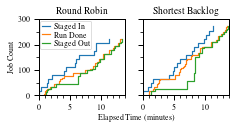

In [36]:
rr_key = ("Round Robin", "Cori")
sb_key = ("Shortest Backlog", "Cori")

def emin(tarr, t0):
    return [(t-t0).total_seconds()/60 for t in tarr]

rr_pre = preprocessed[rr_key]
sb_pre = preprocessed[sb_key]
rr_done = done[rr_key]

sb_done = done[sb_key]
rr_fin = finished[rr_key]
sb_fin = finished[sb_key]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(COLWIDTH, 1.4), sharex=True, sharey=True)
t0 = min(rr_pre)
axes[0].step(emin(rr_pre, t0), range(224), where="post", label="Staged In")
axes[0].step(emin(rr_done, t0), range(224), where="post", label="Run Done")
axes[0].step(emin(rr_fin, t0), range(224), where="post", label="Staged Out")
axes[0].set_title("Round Robin")

t0 = min(sb_pre)
axes[1].step(emin(sb_pre, t0), range(272), where="post", label="Staged In")
axes[1].step(emin(sb_done, t0), range(272), where="post", label="Run Done")
axes[1].step(emin(sb_fin, t0), range(272), where="post", label="Staged Out")
axes[1].set_title("Shortest Backlog")
axes[0].set_xlim(0,14)
axes[1].set_ylim(0, 300)
with plt.rc_context(rc={
    "legend.handlelength":1.0, 
    "legend.labelspacing":0.1, 
    "legend.borderpad": 0.2, 
    "legend.handletextpad": 0.55, 
    "legend.columnspacing": 1.1, 
    "legend.borderaxespad": 0.2
}):
    axes[0].legend()
    axes[0].set_xlabel("Elapsed Time (minutes)", x=1.12)
    axes[0].set_ylabel("Job Count")
    axes[0].xaxis.set_minor_locator(MultipleLocator(1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(50))
    plt.savefig("figures/rr_vs_sb-cori-explanation.pdf", bbox_inches="tight")

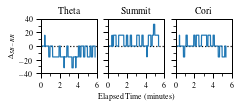

In [49]:
fig, axes =  plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(COLWIDTH,1.0), gridspec_kw={"wspace": 0.20, "hspace": 0.5})
for site, ax in zip(["Theta", "Summit", "Cori"], axes):
    key = ("Round Robin", site)
    round_robin = ready[("Round Robin", site)]
    shortest_backlog = ready[("Shortest Backlog", site)]
    t0 = min(round_robin)
    round_robin = [(t - t0).total_seconds() / 60. for t in round_robin]
    t0 = min(shortest_backlog)
    shortest_backlog = [(t - t0).total_seconds() / 60. for t in shortest_backlog]
    t_grid = np.linspace(start=0, stop=min(max(round_robin), max(shortest_backlog)), num=2000)
    count_rr, count_sb = [], []
    for T in t_grid:
        count_rr.append(len([t for t in round_robin if t <= T]))
        count_sb.append(len([t for t in shortest_backlog if t <= T]))
    count_rr = np.array(count_rr)
    count_sb = np.array(count_sb)
    ax.axhline(0, c='k', ls='dotted')
    ax.plot(t_grid, count_sb - count_rr, label="RR")
    ax.set_xlim(0,6)
    ax.set_xticks([0,2,4,6])
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.set_ylim(-40,40)
    ax.set_yticks([-40,-20,0,20,40])
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.set_title(site)#, x=0.18, y=0.55)
axes[1].set_xlabel("Elapsed Time (minutes)")
axes[0].set_ylabel(r"$\Delta_{SB-RR}$")
plt.savefig("figures/rr_vs_sb_submitted.pdf", bbox_inches="tight")

# Slower RR vs SB (1 task per min)

In [ ]:
tags = {"Round Robin": "round-robin-fast1", "Shortest Backlog": "shortest-backlog1"}

ready = {}
preprocessed = {}
done = {}
finished = {}

for method, exp_tag in tags.items():
    for key, job_qs in experiment_iter(exp_tag):
        assert key[0] == "APS"
        site = key[1]
        print(method, site, job_qs.count())
        qs = EventLog.objects.filter(job_id=[j.id for j in job_qs])
        ready[(method, site)], _ = throughput_report(qs, to_state="READY")
        preprocessed[(method, site)], _ = throughput_report(qs, to_state="PREPROCESSED")
        done[(method, site)], _ = throughput_report(qs, to_state="RUN_DONE")
        finished[(method, site)], _ = throughput_report(qs, to_state="JOB_FINISHED")
        #entry = (source, key[1])
        #if entry in steady_throughput:
        #    steady_throughput[entry].extend(times)
        #else:
        #    steady_throughput[entry] = times